In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

**Purpose of this notebook**

In this Jupyter Notebook we developed and tested the pipeline for the required data pre-processing for Deep Learning. For simplicity and illustrative purposes the workflow is conducted with a single results file from WNTR/Epanet. We tested the training process on this limited data source but didn't use the resulting model for control. We afterwards outsourced this implementation into the file `surrogate_model_training_data.py`. We import the file below to check if outsourcing didn't introduce any bugs.

In [3]:
from surrogate_model_training_data import get_data

# Get Network Information
We load the `.inp` file within the user defined class `testWN` and populate:
```
testWN.wn = wntr.network.WaterNetworkModel(self.__filePath)
```
The class adds some convenience features that act directly on the network, such as:
```
[tank_names, reservoir_names, junction_names] = ctown.getNodeName()
[pump_names, pipe_names, valve_names] = ctown.getLinkName()
```
These names are used throughout this script.

In [4]:
inp_file = '../../WNTR_Model/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_25cl.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_25cl.json')
n_clusters = 25

Get results:

**Note**: Due to size restrictions of the repository, we do not host the data used for training. However,this data can be easily created, with the python scripts in the `WNTR_Model` directory.

In [6]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/results_sim_38_noControls.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

The results are objects created from WNTR. Their structure is explained [here](https://wntr.readthedocs.io/en/latest/resultsobject.html).

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [7]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [8]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


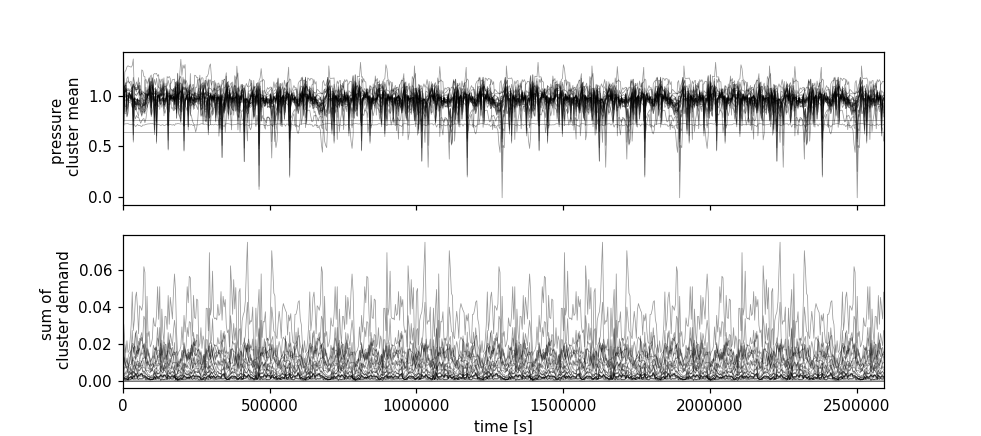

In [9]:
fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[0].set_ylabel('pressure \n cluster mean')


jun_cl_demand_sum.plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[1].set_ylabel('sum of \n cluster demand')

ax[1].set_xlabel('time [s]')
plt.show()

### Tanks

In [10]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

Note that `tank_press` and `tank_press` are identical.

<IPython.core.display.Javascript object>


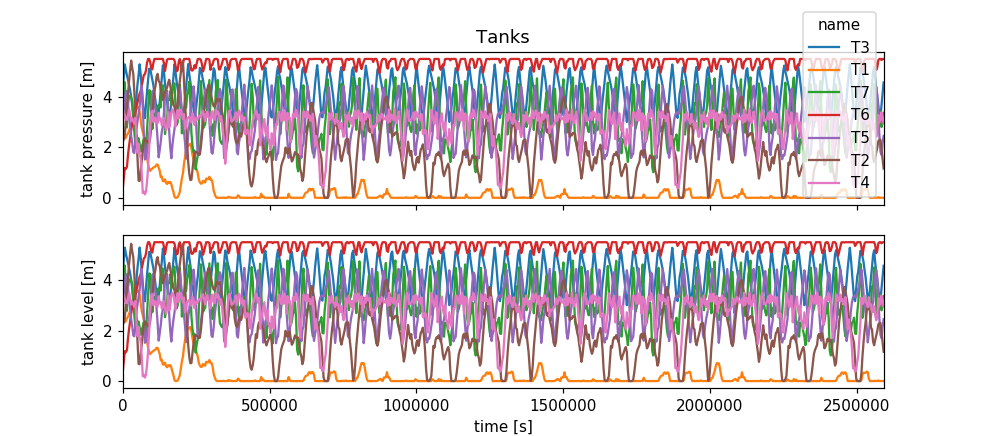

Text(0.5, 0, 'time [s]')

In [11]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,4))
tank_press.plot(ax=ax[0])
ax[0].set_title('Tanks')
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

### Reservoirs

In [12]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


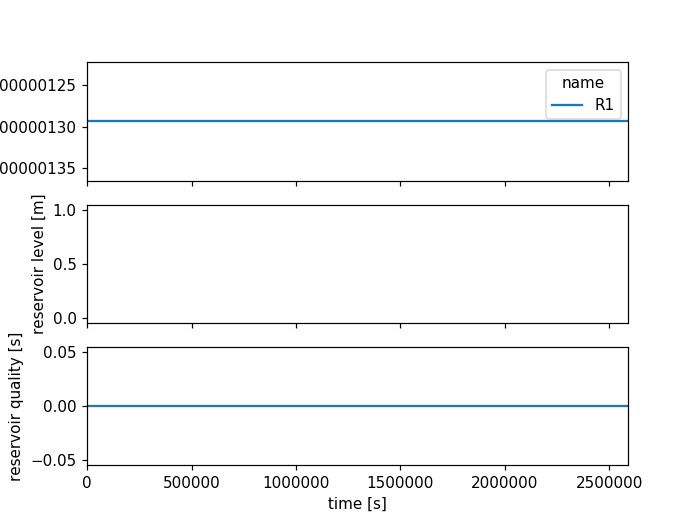

Text(0.5, 0, 'time [s]')

In [13]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

Reservoirs are an infinite source of water. They do not need to be considered explictly for the model.

### Pumps
Pumps are the main control inputs for the system. In the investigated network only head pumps are used.
According to the [API description](https://wntr.readthedocs.io/en/latest/apidoc/wntr.network.elements.html#wntr.network.elements.HeadPump), `setting` determined the speed of the pump:
> **`property setting`**  
> Alias to speed for consistency with other link types

The speed is expressed relative to the normal speed. It is expected to be in the range `0 <= settings <= 1` but can also exceed 1. With rule-based control, `setting` as well as the binary `status` alternate between 0 and 1. Our MPC controller can continously set the speed. However, there is a shutoff threshold. Pump speeds below this threshold (which is different for each pump) set the `status` to zero. Consequently, the pump is off. It was found beneficial for learning the surrogate, to compute:
```python
head_pump_speed_corr = head_pump_speed*head_pump_status
```

In [14]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

<IPython.core.display.Javascript object>


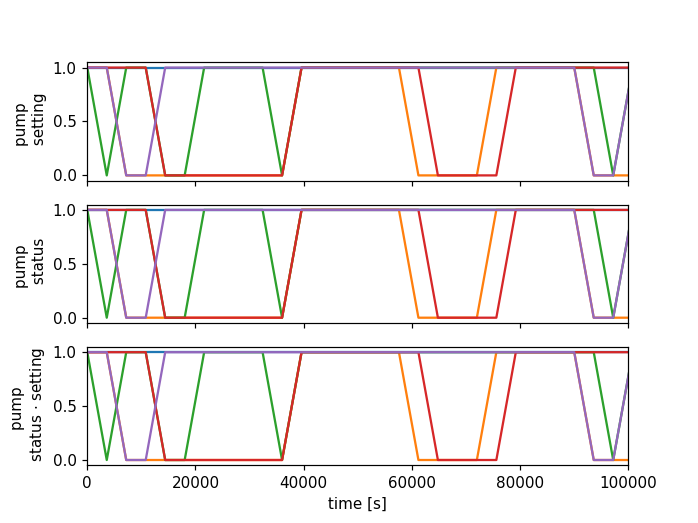

Text(0.5, 0, 'time [s]')

In [15]:
fig, ax = plt.subplots(3,1, sharex=True)
head_pump_speed.plot(ax=ax[0],legend=False)
head_pump_status.plot(ax=ax[1],legend=False)
head_pump_speed_corr.plot(ax=ax[2],legend=False)
ax[0].set_ylabel('pump \n setting')
ax[1].set_ylabel('pump \n status')
ax[2].set_ylabel('pump \n status $\cdot$ setting')
ax[2].set_xlim(0, 100000)
ax[2].set_xlabel('time [s]')

The pump energy is an important output of the neural network which allows for economic MPC. We use the `economics.pump_energy` method ([API description](https://wntr.readthedocs.io/en/latest/apidoc/wntr.metrics.economic.html#wntr.metrics.economic.pump_energy)) to compute the value. We convert the power to kW for better readability.

In [16]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,58.639860,30.424565,57.962059,30.480667,20.643030
3600,58.991786,30.465109,0.000000,30.466038,21.101581
7200,59.698231,0.000000,57.952243,30.284526,0.000000


<IPython.core.display.Javascript object>


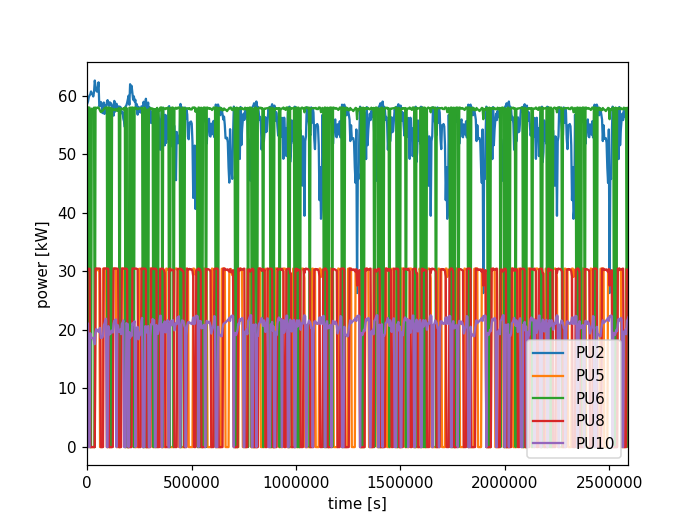

Text(0.5, 0, 'time [s]')

In [17]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves
Valves are additional control inputs to steer the system. We have two kinds of valves in the investigated network:
- [Pressure reducing valves (PRV)](https://wntr.readthedocs.io/en/latest/apidoc/wntr.network.elements.html#wntr.network.elements.PRValve)
- [Throttle control valves (TCV)](https://wntr.readthedocs.io/en/latest/apidoc/wntr.network.elements.html#wntr.network.elements.TCValve)  

We are again able to control the  `setting` parameter for both valves (which is different in its effect). The valves are only used occasionally in the original setup of the investigated network (with rule based control).

In [18]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


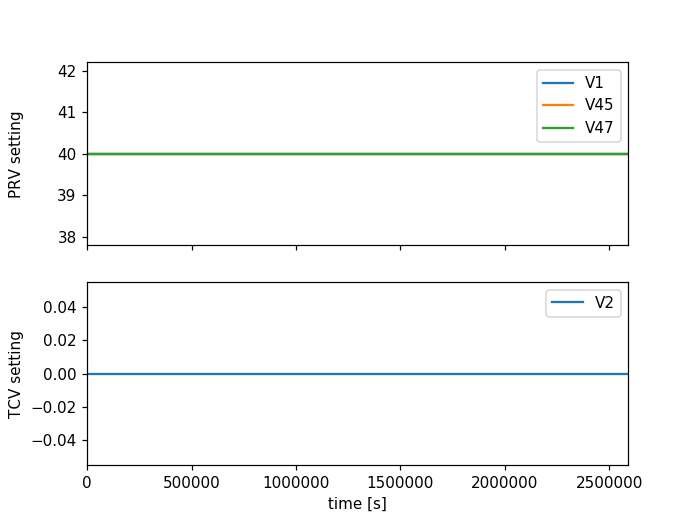

In [19]:
fig, ax = plt.subplots(2, sharex=True)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])
ax[0].set_ylabel('PRV setting')
ax[1].set_ylabel('TCV setting')
ax[1].set_xlabel('time [s]')

fig.align_ylabels()

## Neural Network Pre-Processing
### States and Inputs
We define states, inputs and auxiliary outputs of the neural network:

In [20]:
state_dict = {
              'tank_press': tank_press,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed_corr,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,
                  'jun_cl_press_mean': jun_cl_press_mean}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [21]:
dsys_states = sys_states.diff(axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': dsys_states_next,
                 #'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs,
                 }
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [22]:
nn_output.head(3)

sys_states                                                              \
     tank_press                                                               
             T3        T1        T7        T6        T5        T2        T4   
0      0.506508 -0.258896  0.413938  0.403864  0.367485  0.110212  0.536963   
3600   0.459749 -0.191630  0.545511  0.414077  0.495365  0.189156 -0.122095   
7200  -0.241511  0.038746 -1.277894 -0.038416  0.177952  0.580676 -0.176882   

     aux_outputs                        ...                              \
     pump_energy                        ... jun_cl_press_mean             
             PU2        PU5        PU6  ...                15        16   
0      58.639860  30.424565  57.962059  ...          0.723723  1.037184   
3600   58.991786  30.465109   0.000000  ...          0.719770  1.058943   
7200   59.698231   0.000000  57.952243  ...          0.724226  1.049690   

                                                                            \
                                                                             
            17        18        19        20        21        22        23   
0     1.163831  0.984517  0.639265  1.016542  0.956371  1.071162  1.047923   
3600  1.176410  0.936594  0.639044  1.076658  0.978145  0.703336  0.726414   
7200  0.996466  1.004409  0.639277  1.068447  1.242516  1.101142  1.069634   

                
                
            24  
0     0.954578  
3600  1.026219  
7200  0.828032  

[3 rows x 37 columns]

Inputs of the neural network:

In [23]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys(), names=['type', 'name', 'index'])

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (721, 41)


Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [24]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=720, n_inputs = 41, n_outputs=37


### Compare to external output function:

As discussed above, we outsource the functionality of this script into a python script: `surrogate_model_training_data.py` which can be used on lists of results files to create an extensive training data set. We check if the outsourced file creates the same neural network I/O for the investigated results file:

In [25]:
file_list = [file]

n_arx = 0
nn_input_ext, nn_output_ext = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

In [26]:
print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input_ext.shape, nn_output_ext.shape[1]))

n_samples=720, n_inputs = 41, n_outputs=37


In [27]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [40]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [42]:
X_train.shape

(576, 41)

# Neural Network

## Create Model

In [43]:
n_layer = 4          # This includes the output layer. n_layer-1 is the number of hidden layers.
n_units = 50         # Number of units per hidden layer.  
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 37)                1887      
Total params: 9,087
Trainable params: 9,087
Non-trainable params: 0
_________________________________________________________________


## Train model

In [44]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [45]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=100, 
                    epochs=1000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 576 samples, validate on 144 samples
Epoch 1/1000
576/576 [==============================] - 1s 2ms/sample - loss: 0.5195 - val_loss: 0.3422
Epoch 2/1000
576/576 [==============================] - 0s 204us/sample - loss: 0.2714 - val_loss: 0.1951
Epoch 3/1000
576/576 [==============================] - 0s 154us/sample - loss: 0.1554 - val_loss: 0.1186
Epoch 4/1000
576/576 [==============================] - 0s 158us/sample - loss: 0.0943 - val_loss: 0.0750
Epoch 5/1000
576/576 [==============================] - 0s 186us/sample - loss: 0.0602 - val_loss: 0.0548
Epoch 6/1000
576/576 [==============================] - 0s 257us/sample - loss: 0.0485 - val_loss: 0.0494
Epoch 7/1000
576/576 [==============================] - 0s 180us/sample - loss: 0.0455 - val_loss: 0.0465
Epoch 8/1000
576/576 [==============================] - 0s 183us/sample - loss: 0.0428 - val_loss: 0.0438
Epoch 9/1000
576/576 [==============================] - 0s 209us/sample - loss: 0.0399 - val_loss: 0.0415
Ep

576/576 [==============================] - 0s 123us/sample - loss: 0.0069 - val_loss: 0.0086
Epoch 154/1000
576/576 [==============================] - 0s 109us/sample - loss: 0.0069 - val_loss: 0.0084
Epoch 155/1000
576/576 [==============================] - 0s 105us/sample - loss: 0.0069 - val_loss: 0.0085
Epoch 156/1000
576/576 [==============================] - 0s 106us/sample - loss: 0.0068 - val_loss: 0.0084
Epoch 157/1000
576/576 [==============================] - 0s 119us/sample - loss: 0.0069 - val_loss: 0.0084
Epoch 158/1000
576/576 [==============================] - 0s 115us/sample - loss: 0.0068 - val_loss: 0.0083
Epoch 159/1000
576/576 [==============================] - 0s 131us/sample - loss: 0.0068 - val_loss: 0.0083
Epoch 160/1000
576/576 [==============================] - 0s 111us/sample - loss: 0.0068 - val_loss: 0.0084
Epoch 161/1000
576/576 [==============================] - 0s 119us/sample - loss: 0.0068 - val_loss: 0.0082
Epoch 162/1000
576/576 [===================

Epoch 229/1000
576/576 [==============================] - 0s 180us/sample - loss: 0.0061 - val_loss: 0.0073
Epoch 230/1000
576/576 [==============================] - 0s 337us/sample - loss: 0.0060 - val_loss: 0.0074
Epoch 231/1000
576/576 [==============================] - 0s 309us/sample - loss: 0.0060 - val_loss: 0.0075
Epoch 232/1000
576/576 [==============================] - 0s 168us/sample - loss: 0.0061 - val_loss: 0.0073
Epoch 233/1000
576/576 [==============================] - 0s 159us/sample - loss: 0.0061 - val_loss: 0.0075
Epoch 234/1000
576/576 [==============================] - 0s 248us/sample - loss: 0.0061 - val_loss: 0.0073
Epoch 235/1000
576/576 [==============================] - 0s 227us/sample - loss: 0.0060 - val_loss: 0.0079
Epoch 236/1000
576/576 [==============================] - 0s 149us/sample - loss: 0.0061 - val_loss: 0.0076
Epoch 237/1000
576/576 [==============================] - 0s 145us/sample - loss: 0.0060 - val_loss: 0.0073
Epoch 238/1000
576/576 [====

Epoch 305/1000
576/576 [==============================] - 0s 201us/sample - loss: 0.0057 - val_loss: 0.0069
Epoch 306/1000
576/576 [==============================] - 0s 190us/sample - loss: 0.0057 - val_loss: 0.0068
Epoch 307/1000
576/576 [==============================] - 0s 194us/sample - loss: 0.0058 - val_loss: 0.0070
Epoch 308/1000
576/576 [==============================] - 0s 211us/sample - loss: 0.0058 - val_loss: 0.0069
Epoch 309/1000
576/576 [==============================] - 0s 197us/sample - loss: 0.0056 - val_loss: 0.0070
Epoch 310/1000
576/576 [==============================] - 0s 185us/sample - loss: 0.0055 - val_loss: 0.0068
Epoch 311/1000
576/576 [==============================] - 0s 190us/sample - loss: 0.0055 - val_loss: 0.0071
Epoch 312/1000
576/576 [==============================] - 0s 302us/sample - loss: 0.0056 - val_loss: 0.0071
Epoch 313/1000
576/576 [==============================] - 0s 195us/sample - loss: 0.0055 - val_loss: 0.0071
Epoch 314/1000
576/576 [====

Epoch 381/1000
576/576 [==============================] - 0s 265us/sample - loss: 0.0051 - val_loss: 0.0064
Epoch 382/1000
576/576 [==============================] - 0s 171us/sample - loss: 0.0051 - val_loss: 0.0064
Epoch 383/1000
576/576 [==============================] - 0s 273us/sample - loss: 0.0051 - val_loss: 0.0066
Epoch 384/1000
576/576 [==============================] - 0s 382us/sample - loss: 0.0052 - val_loss: 0.0063
Epoch 385/1000
576/576 [==============================] - 0s 210us/sample - loss: 0.0051 - val_loss: 0.0064
Epoch 386/1000
576/576 [==============================] - 0s 201us/sample - loss: 0.0050 - val_loss: 0.0063
Epoch 387/1000
576/576 [==============================] - 0s 187us/sample - loss: 0.0050 - val_loss: 0.0062
Epoch 388/1000
576/576 [==============================] - 0s 216us/sample - loss: 0.0051 - val_loss: 0.0063
Epoch 389/1000
576/576 [==============================] - 0s 185us/sample - loss: 0.0050 - val_loss: 0.0063
Epoch 390/1000
576/576 [====

Epoch 457/1000
576/576 [==============================] - 0s 166us/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 458/1000
576/576 [==============================] - 0s 158us/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 459/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 460/1000
576/576 [==============================] - 0s 137us/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 461/1000
576/576 [==============================] - 0s 146us/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 462/1000
576/576 [==============================] - 0s 199us/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 463/1000
576/576 [==============================] - 0s 322us/sample - loss: 0.0047 - val_loss: 0.0062
Epoch 464/1000
576/576 [==============================] - 0s 212us/sample - loss: 0.0048 - val_loss: 0.0062
Epoch 465/1000
576/576 [==============================] - 0s 184us/sample - loss: 0.0047 - val_loss: 0.0060
Epoch 466/1000
576/576 [====

Epoch 533/1000
576/576 [==============================] - 0s 157us/sample - loss: 0.0044 - val_loss: 0.0057
Epoch 534/1000
576/576 [==============================] - 0s 142us/sample - loss: 0.0044 - val_loss: 0.0057
Epoch 535/1000
576/576 [==============================] - 0s 137us/sample - loss: 0.0045 - val_loss: 0.0058
Epoch 536/1000
576/576 [==============================] - 0s 155us/sample - loss: 0.0045 - val_loss: 0.0057
Epoch 537/1000
576/576 [==============================] - 0s 177us/sample - loss: 0.0044 - val_loss: 0.0057
Epoch 538/1000
576/576 [==============================] - 0s 144us/sample - loss: 0.0044 - val_loss: 0.0059
Epoch 539/1000
576/576 [==============================] - 0s 138us/sample - loss: 0.0044 - val_loss: 0.0056
Epoch 540/1000
576/576 [==============================] - 0s 158us/sample - loss: 0.0044 - val_loss: 0.0056
Epoch 541/1000
576/576 [==============================] - 0s 140us/sample - loss: 0.0044 - val_loss: 0.0058
Epoch 542/1000
576/576 [====

Epoch 609/1000
576/576 [==============================] - 0s 165us/sample - loss: 0.0041 - val_loss: 0.0053
Epoch 610/1000
576/576 [==============================] - 0s 159us/sample - loss: 0.0040 - val_loss: 0.0054
Epoch 611/1000
576/576 [==============================] - 0s 195us/sample - loss: 0.0041 - val_loss: 0.0053
Epoch 612/1000
576/576 [==============================] - 0s 157us/sample - loss: 0.0040 - val_loss: 0.0052
Epoch 613/1000
576/576 [==============================] - 0s 149us/sample - loss: 0.0040 - val_loss: 0.0053
Epoch 614/1000
576/576 [==============================] - 0s 167us/sample - loss: 0.0040 - val_loss: 0.0053
Epoch 615/1000
576/576 [==============================] - 0s 150us/sample - loss: 0.0040 - val_loss: 0.0053
Epoch 616/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0041 - val_loss: 0.0052
Epoch 617/1000
576/576 [==============================] - 0s 166us/sample - loss: 0.0040 - val_loss: 0.0052
Epoch 618/1000
576/576 [====

576/576 [==============================] - 0s 101us/sample - loss: 0.0035 - val_loss: 0.0049
Epoch 762/1000
576/576 [==============================] - 0s 98us/sample - loss: 0.0034 - val_loss: 0.0050
Epoch 763/1000
576/576 [==============================] - 0s 93us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 764/1000
576/576 [==============================] - 0s 100us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 765/1000
576/576 [==============================] - 0s 101us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 766/1000
576/576 [==============================] - 0s 93us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 767/1000
576/576 [==============================] - 0s 95us/sample - loss: 0.0033 - val_loss: 0.0047
Epoch 768/1000
576/576 [==============================] - 0s 140us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 769/1000
576/576 [==============================] - 0s 105us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 770/1000
576/576 [=======================

576/576 [==============================] - 0s 143us/sample - loss: 0.0028 - val_loss: 0.0047
Epoch 914/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0029 - val_loss: 0.0046
Epoch 915/1000
576/576 [==============================] - 0s 145us/sample - loss: 0.0029 - val_loss: 0.0045
Epoch 916/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0028 - val_loss: 0.0046
Epoch 917/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0028 - val_loss: 0.0045
Epoch 918/1000
576/576 [==============================] - 0s 150us/sample - loss: 0.0029 - val_loss: 0.0045
Epoch 919/1000
576/576 [==============================] - 0s 142us/sample - loss: 0.0028 - val_loss: 0.0045
Epoch 920/1000
576/576 [==============================] - 0s 189us/sample - loss: 0.0028 - val_loss: 0.0045
Epoch 921/1000
576/576 [==============================] - 0s 163us/sample - loss: 0.0028 - val_loss: 0.0045
Epoch 922/1000
576/576 [===================

## Evaluate model
We introduce a very simple simulator class, which can recursively evaluate the trained model. This requires an initial state and at each evaluation step the current control input. Open loop simulations allow for a decent benchmark of the trained model. 

Note that the simulator is very slow and is only used for internal testing.

In [46]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

We set the intial state and time and initilize the simulator object:

In [78]:
x0 = sys_states.iloc[0].to_numpy().reshape(1,-1)
t0 = sys_states.iloc[0].name

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

The simulator is evaluated recursively for `n` steps and we retrieve the solution as pandas DataFrames.

In [79]:
n_sim_steps = 100
for k in range(n_sim_steps):
    print('{:.2f}% complete'.format(100*(k+1)/n_sim_steps), end="\r")
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = aux_outputs.columns,index=nsim.t.flatten()[:-1])

<IPython.core.display.Javascript object>


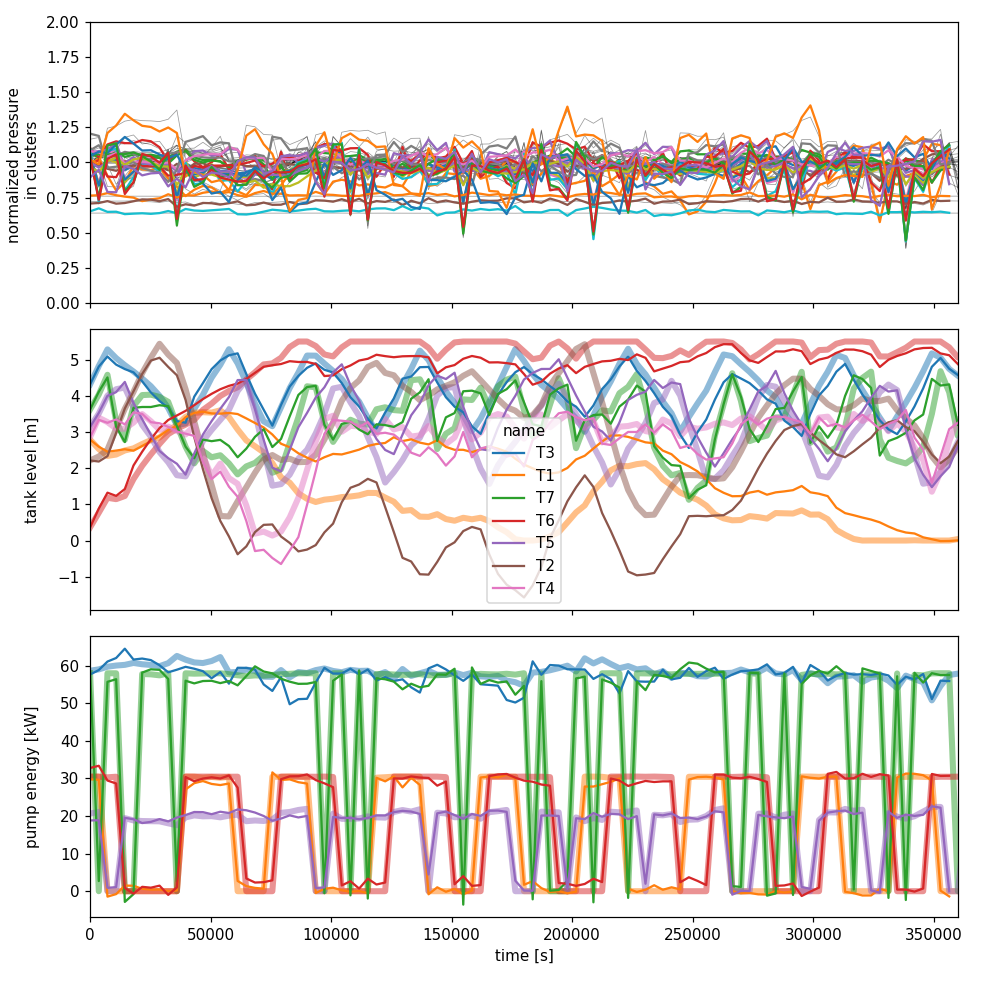

In [80]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

pump_energy.plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylim(0, 2)
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump energy [kW]')
ax[2].set_xlabel('time [s]')

fig.align_ylabels()
fig.tight_layout()

The results look quite satisfying. Note that an open-loop simulation is not equivalent to a validation on the training dataset. While it is true, that we use known inputs and demands, errors in the state prediction are propagating and we deviate from the original training dataset. The fact that the open loop tank level predictions are quantitatively and qualitatively accurate is very promising. 

# Linear Model
We also investigated a linear model with the same I/O structure. The `simulator` class defined above can also be used for this model.

In [72]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [73]:
x0 = sys_states.iloc[0].to_numpy().reshape(1,-1)
t0 = sys_states.iloc[0].name

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [74]:
n_sim_steps = 100
for k in range(n_sim_steps):
    print('{:.2f}% complete'.format(100*(k+1)/n_sim_steps), end="\r")
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

<IPython.core.display.Javascript object>


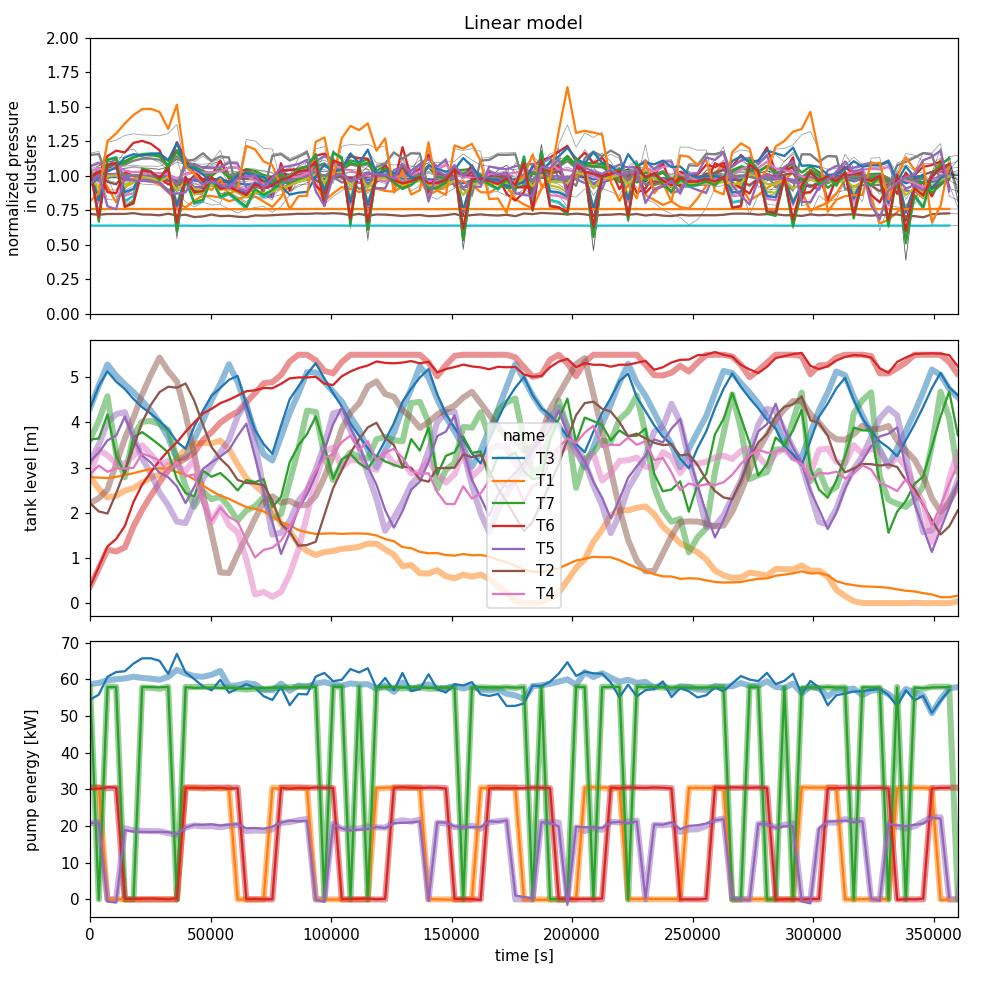

In [77]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1])

pump_energy.plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_title('Linear model')
ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylim(0, 2)
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump energy [kW]')
ax[2].set_xlabel('time [s]')

fig.align_ylabels()
fig.tight_layout()

The linear model performs also very good for the small dataset. However, we see that on the larger dataset the neural network significantly outperforms the linear model. This is shown in the jupyter notebook: `dnn_surrogate_full_model.ipynb`.